In [4]:
%pylab inline

from __future__ import division

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
from matplotlib.collections import PatchCollection
from mpl_toolkits.mplot3d import Axes3D

from ipywidgets import interact, HTML, FloatSlider
from IPython.display import clear_output, display

import numba as nb
import time

Populating the interactive namespace from numpy and matplotlib


In [5]:
G = 6.67e-8

dt = 1e0
stepN = 100
h = 2e9

In [6]:
### --- Distribution Case 1 --- ###
# xyDistribution = np.array(([1.0e8, 1.0e8], 
#                            [-1.0e8, -1.0e8])) 
# nParticles = len(xyDistribution)

### --- Distribution Case 1.5 --- ###
# xyDistribution = np.array(([1.0e8, 1.0e8], 
#                            [-1.0e8, -1.0e8],
#                            [0.0, 1.0e8]))
# nParticles = len(xyDistribution)

### --- Distribution Case 2 --- ###
nParticles = 250
xyDistribution = np.random.normal(0, 5e7, size = (nParticles, 2))
# Velocity and mass distribution
velocityDistribution = np.zeros_like(xyDistribution, dtype = np.float)

mDistribution = np.ones(nParticles, dtype=float) * 2e27

# Pressure and density based off of what we're seeing in Jupiter
pressureDistribution = np.ones(nParticles, dtype=float) * 4e13
rhoDistribution = np.ones(nParticles, dtype=float) * 3

ParticlePositionHistory = np.zeros((nParticles,2,stepN))
ParticleVelocityHistory = np.zeros((nParticles,2,stepN))


timeArray = np.arange(0, stepN*dt, dt)

[]

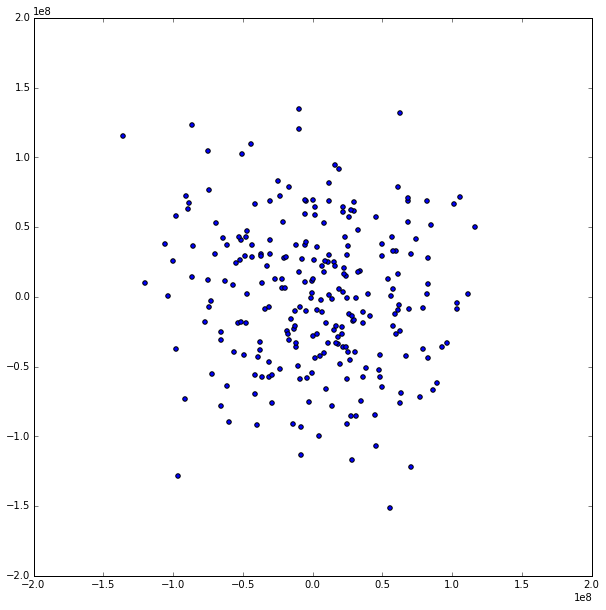

In [7]:
plt.figure(figsize=(10,10))
plt.scatter(xyDistribution[:,0], xyDistribution[:,1], c='b')
plt.xlim(-2e8, 2e8)
plt.ylim(-2e8, 2e8)
plt.plot()

In [8]:
def gravity(xyDistribution):
    
    global velocityDistribution
#    global xyDistribution
    global h
    
    deltaV = np.zeros_like(xyDistribution, dtype = np.float)
    for j in range(0, nParticles):
        for k in range(0, nParticles):
            if (k!=j):
                xdist = (xyDistribution[j,0]-xyDistribution[k,0])
                ydist = (xyDistribution[j,1]-xyDistribution[k,1])
#                print xyDistribution
#                print "xdist:", xdist
#                print(ydist)

                if(abs(xdist)<1e7):
#                    deltaV[j,0] -= -G*mDistribution[j]*xdist/((np.sqrt(xdist**2+ydist**2))**3)
                    deltaV[j,0] -= 0
#                    print "X less than smoothing"
                else:
                    deltaV[j,0] += -G*mDistribution[j]*xdist/((np.sqrt(xdist**2+ydist**2))**3)

                if(abs(ydist)<1e7):
#                    deltaV[j,1] -= -G*mDistribution[j]*ydist/((np.sqrt(xdist**2+ydist**2))**3)
                    deltaV[j,1] -= 0
#                    print "Y less than smoothing"
                else:
                    deltaV[j,1] += -G*mDistribution[j]*ydist/((np.sqrt(xdist**2+ydist**2))**3)
                    
    return deltaV

nb_gravity = nb.autojit(gravity)

In [9]:
# RK1 Parameters
t0 = time.time()
t = 0
#dt = 1e1
#stepN = 20

# Particle history
ParticlePositionHistory = np.zeros((stepN,nParticles,2))
ParticleRhoHistory = np.zeros((stepN, nParticles, 1))
xyDistributionOld = np.copy(xyDistribution)
# Velocity History
ParticleVelocityHistory = np.zeros((stepN,nParticles,2))

# Force history
forceHistory = np.zeros((stepN, 3))

for i in range(stepN):
    if i % 50 == 0:
        print "Time step", i
    if i == 2:
        rhoOld = np.copy(rhoDistribution)
    deltaVf = np.zeros_like(xyDistribution, dtype = np.float)
    
    t += 1
    ParticlePositionHistory[i,:,:] = xyDistribution
    ParticleVelocityHistory[i,:,:] = velocityDistribution
    
    deltaVf += nb_gravity(xyDistribution) 
#    print "\nAvg gravity", np.mean(deltaVf)
    forceHistory[i,0] = np.median(deltaVf)
    
    
#     deltaVf -= -gradP()/rhoDistribution[:,np.newaxis]
# #    print "Avg gravity + pressure", np.mean(deltaVf)
#     forceHistory[i,1] = np.mean(deltaVf)

#    deltaVf +=  -v*velocityDistribution**1
#    print "Avg damping:", np.mean(velocityDistribution)    
#    forceHistory[i,2] = np.mean(-v*velocityDistribution**1)
    
    velocityDistribution += dt*deltaVf    
    xyDistribution += dt*velocityDistribution

#    densityUpdate()
#    ParticleRhoHistory[i,:,:] = rhoDistribution[:,np.newaxis]
#    pressureDistribution = K*rhoDistribution**2

    ### --- DEBUGGING --- ###
#    print xyDistribution[0,0] - xyDistribution[1,0]


print(time.time()-t0)
#print(rhoDistribution-rhoOld)
#print(xyDistribution-xyDistributionOld) 


Time step 0
Time step 50
0.431197166443


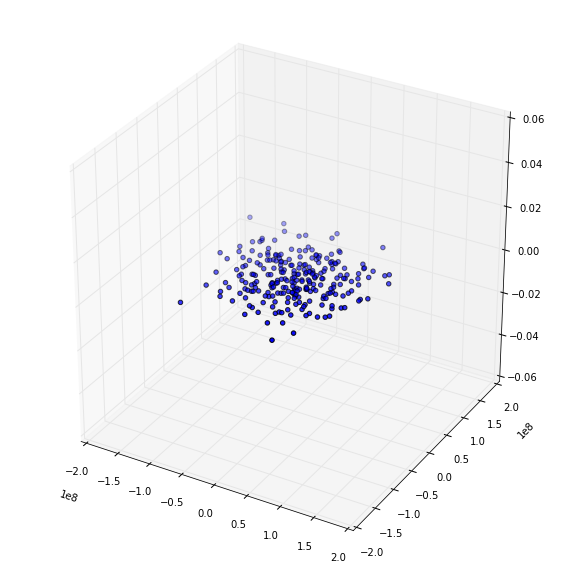

In [15]:
slider = FloatSlider(description='Time', min=1, max=stepN, step=1)

def update_plot():
    time=slider.value
    x = ParticlePositionHistory[time-1,:,0]
    y = ParticlePositionHistory[time-1,:,1]
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(x, y, 0)
#     fig = plt.figure(figsize=(10,10))
#     plt.scatter(x, y)
    plt.xlim(-2e8,2e8)
    plt.ylim(-2e8,2e8)
    #plt.zlim(-2e8,2e8)

    clear_output(True)

slider.on_trait_change(update_plot, 'value')


display(slider)
update_plot()

[[ -1.38547707e+08   5.22902327e+06]
 [  4.89978780e+07  -3.29528469e+08]
 [  6.07348538e+08  -5.52309632e+08]
 [ -1.40095636e+08  -9.55803083e+06]
 [ -1.08560655e+08  -2.10785982e+08]
 [  3.11682134e+07  -2.36347494e+08]
 [  2.23511990e+08  -2.69556112e+07]
 [ -1.46129348e+08  -5.46620644e+07]
 [ -1.14645053e+08  -7.20544492e+07]
 [ -7.84623168e+07  -3.88673186e+07]
 [ -1.02153646e+08  -6.01830621e+07]
 [ -4.36543878e+07   2.29017971e+08]
 [ -1.41740828e+09  -7.04900137e+08]
 [ -2.29346667e+09  -1.11479213e+09]
 [ -1.02883508e+08  -4.96796239e+07]
 [ -1.00219733e+08   1.70990484e+08]
 [ -2.72111942e+09   7.26521719e+08]
 [ -8.49063060e+07  -6.66428627e+07]
 [  6.04193337e+07  -1.26753815e+08]
 [  1.62741326e+08  -1.70221157e+08]
 [ -1.11510403e+08   1.69909499e+07]
 [ -4.41623780e+08   8.47648112e+08]
 [ -1.07675504e+08  -6.97608461e+07]
 [ -1.92788186e+08  -4.17485991e+08]
 [  2.71570045e+09  -1.12465312e+09]
 [ -1.80524438e+08  -1.73816058e+08]
 [ -4.80743541e+07  -3.78068527e+07]
 

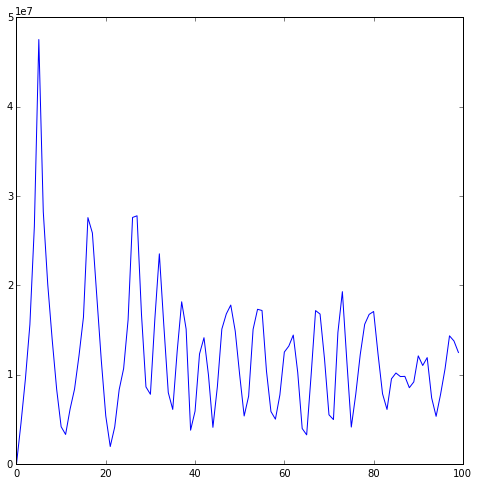

In [11]:
plt.figure(figsize=(8,8))
# plt.plot(range(stepN), forceHistory[:,0], label='gravity')
plt.plot(range(stepN), abs(np.sqrt((ParticleVelocityHistory[:,0,0])**2+(ParticleVelocityHistory[:,0,1])**2)))
print(xyDistribution-xyDistributionOld)

Velocity Asymptotes $\implies$ Force goes to zero (Good thing)